In [1]:
# This notebook requires gym==0.19.0 and pyglet==1.5.27

In [2]:
import numpy as np
from typing import Sequence, NamedTuple, Any

import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.linen.initializers import constant, orthogonal
from flax.training.train_state import TrainState
import optax
import orbax.checkpoint
import distrax
import gymnax
from gymnax.visualize import Visualizer

In [3]:
class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0))(actor_mean)
        pi = distrax.Categorical(logits=actor_mean)

        critic = nn.Dense(64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(x)
        critic = activation(critic)
        critic = nn.Dense(64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(critic)

        return pi, jnp.squeeze(critic, axis=-1)

In [4]:
config = {
    "LR": 2.5e-4,
    "NUM_ENVS": 5,
    "NUM_STEPS": 128,
    "TOTAL_TIMESTEPS": 5e5,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": 4,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.01,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "tanh",
    "ENV_NAME": "CartPole-v1",
    "ANNEAL_LR": True,
}

In [5]:
env, env_params = gymnax.make(config["ENV_NAME"])

In [6]:
rng = jax.random.PRNGKey(42)

In [7]:
network = ActorCritic(env.action_space(env_params).n, activation=config["ACTIVATION"])
rng, _rng = jax.random.split(rng)
init_x = jnp.zeros(env.observation_space(env_params).shape)
network_params = network.init(_rng, init_x)

def linear_schedule(count):
    frac = 1.0 - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"])) / config["NUM_UPDATES"]
    return config["LR"] * frac

if config["ANNEAL_LR"]:
    tx = optax.chain(optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),)
else:
    tx = optax.chain(optax.clip_by_global_norm(config["MAX_GRAD_NORM"]), 
                optax.adam(config["LR"], eps=1e-5))
    
empty_state = TrainState.create(apply_fn=network.apply, params=network_params, tx=tx,)

In [8]:
ckpt_dir = 'ckpt_cartpole'
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
state = orbax_checkpointer.restore(ckpt_dir, item=empty_state)

In [9]:
def rollout_episode(env, env_params, state, max_frames=200):
    state_seq = []
    rng = jax.random.PRNGKey(0)

    rng, rng_reset = jax.random.split(rng)
    obs, env_state = env.reset(rng_reset, env_params)

    t_counter = 0
    reward_seq = []
    
    while True:
        state_seq.append(env_state)
        rng, rng_act, rng_step = jax.random.split(rng, 3)
        pi, v = state.apply_fn(state.params, obs)
        action = pi.sample(seed=rng_act)
        next_obs, next_env_state, reward, done, info = env.step(rng_step, env_state, action, env_params)
        reward_seq.append(reward)
        print(t_counter, reward, action, done)
        print(10 * "=")
        t_counter += 1
        if done or t_counter == max_frames:
            break
        else:
            env_state = next_env_state
            obs = next_obs
    print(f"{env.name} - Steps: {t_counter}, Return: {np.sum(reward_seq)}")
    return state_seq, np.cumsum(reward_seq)

In [10]:
state_seq, cum_rewards = rollout_episode(env, env_params, state)

0 1.0 1 False
1 1.0 0 False
2 1.0 1 False
3 1.0 0 False
4 1.0 1 False
5 1.0 0 False
6 1.0 1 False
7 1.0 0 False
8 1.0 1 False
9 1.0 0 False
10 1.0 1 False
11 1.0 0 False
12 1.0 0 False
13 1.0 1 False
14 1.0 0 False
15 1.0 0 False
16 1.0 0 False
17 1.0 1 False
18 1.0 0 False
19 1.0 1 False
20 1.0 1 False
21 1.0 1 False
22 1.0 0 False
23 1.0 0 False
24 1.0 1 False
25 1.0 0 False
26 1.0 1 False
27 1.0 1 False
28 1.0 0 False
29 1.0 0 False
30 1.0 1 False
31 1.0 1 False
32 1.0 0 False
33 1.0 0 False
34 1.0 1 False
35 1.0 0 False
36 1.0 0 False
37 1.0 0 False
38 1.0 1 False
39 1.0 1 False
40 1.0 1 False
41 1.0 1 False
42 1.0 0 False
43 1.0 1 False
44 1.0 0 False
45 1.0 1 False
46 1.0 0 False
47 1.0 0 False
48 1.0 1 False
49 1.0 1 False
50 1.0 1 False
51 1.0 0 False
52 1.0 0 False
53 1.0 0 False
54 1.0 1 False
55 1.0 0 False
56 1.0 1 False
57 1.0 1 False
58 1.0 0 False
59 1.0 1 False
60 1.0 0 False
61 1.0 0 False
62 1.0 1 False
63 1.0 0 False
64 1.0 1 False
65 1.0 1 False
66 1.0 1 False
67 1.

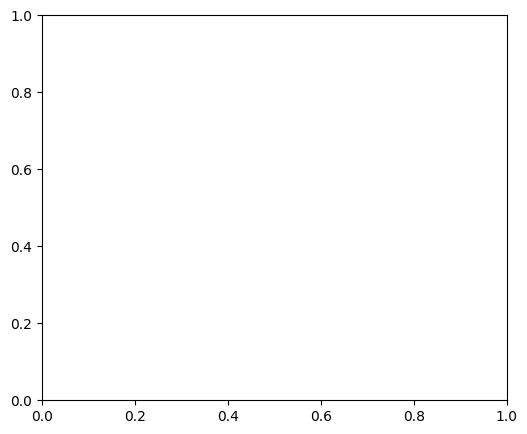

In [11]:
vis = Visualizer(env, env_params, state_seq, cum_rewards)

In [12]:
vis.animate(f"cartpole.gif")